In [3]:
import numpy as np
import pandas as pd
import datetime

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

plt.style.use('seaborn-darkgrid')
plt.rc('figure', figsize=(16,10))
plt.rc('lines', markersize=4)

import yfinance as yf

from sklearn.linear_model import LinearRegression

## Get a sample stock price from 2019-01-01 to today

In [4]:
# Get the data of the Apple stock (code AAPL)
data = yf.download('AAPL','2019-01-01','2020-04-30')
data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-12-31,158.529999,159.360001,156.479996,157.740005,154.618546,35003500
2019-01-02,154.889999,158.850006,154.229996,157.919998,154.794983,37039700
2019-01-03,143.979996,145.720001,142.000000,142.190002,139.376251,91312200
2019-01-04,144.529999,148.550003,143.800003,148.259995,145.326126,58607100
2019-01-07,148.699997,148.830002,145.899994,147.929993,145.002686,54777800


In [5]:
df = pd.DataFrame(data, columns=['Close'])
df = df.reset_index()
df.isna().values.any() # check for NaN

False

/Users/elchapo/miniconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
Matplotlib is building the font cache using fc-list. This may take a moment.


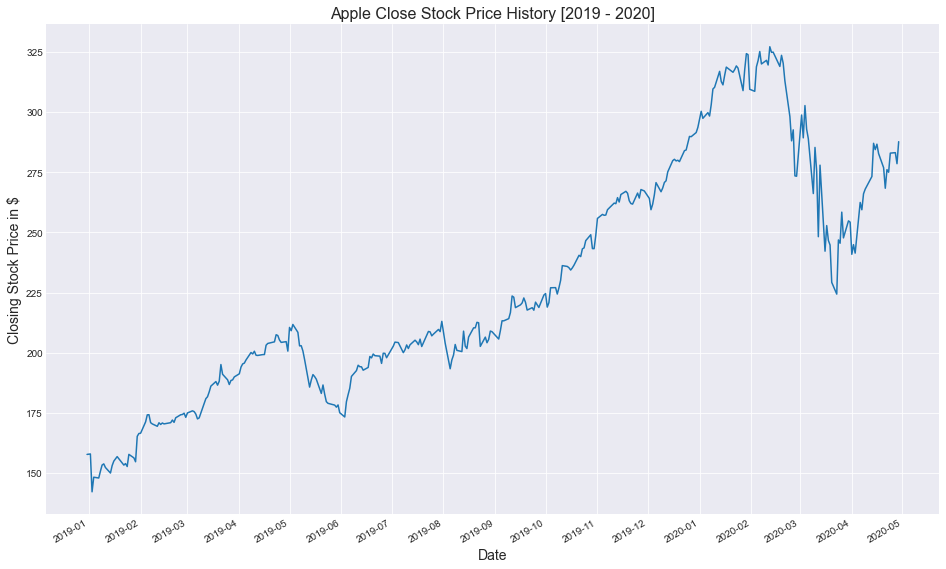

In [6]:
# Import matplotlib package for date plots

months = mdates.MonthLocator() # Get every year
dateFmt = mdates.DateFormatter('%Y-%m') # Set year format

# Create subplots to plot graph and control axes
fig, ax = plt.subplots()
ax.plot(df['Date'], df['Close'])

# Format the ticks
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(dateFmt)

# Set figure title
plt.title('Apple Close Stock Price History [2019 - 2020]', fontsize=16)
# Set x label
plt.xlabel('Date', fontsize=14)
# Set y label
plt.ylabel('Closing Stock Price in $', fontsize=14)

# Rotate and align the x labels
fig.autofmt_xdate()

# Show plot
plt.show()

In [8]:
def get_close_stock_price(codes, start_date='2019-01-01', end_date='2020-04-30'):
    data = { code : yf.download(code, start_date, end_date) for code in codes }
    data = { key : pd.DataFrame(value, columns=['Close']).rename(columns={'Close': f'{key}'}) for key, value in data.items() }
    df = None
    for key, value in data.items():
        if df is None:
            df = value
        else:
            df = df.merge(value, left_index=True, right_index=True)
    return df

df = get_close_stock_price(['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'FB'])
df.to_csv('data/close_price_big_5.csv')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [11]:
df = pd.read_csv('data/close_price_big_5.csv', index_col=['Date'], infer_datetime_format=True, parse_dates=['Date'])
df

,AAPL,GOOGL,MSFT,AMZN,FB
Date,,,,,
2018-12-31,157.740005,1044.959961,101.570000,1501.969971,131.089996
2019-01-02,157.919998,1054.680054,101.120003,1539.130005,135.679993
2019-01-03,142.190002,1025.469971,97.400002,1500.280029,131.740005
2019-01-04,148.259995,1078.069946,101.930000,1575.390015,137.949997
2019-01-07,147.929993,1075.920044,102.059998,1629.510010,138.050003
...,...,...,...,...,...
2020-04-23,275.029999,1271.170044,171.419998,2399.449951,185.130005
2020-04-24,282.970001,1276.599976,174.550003,2410.219971,190.070007
2020-04-27,283.170013,1270.859985,174.050003,2376.000000,187.500000


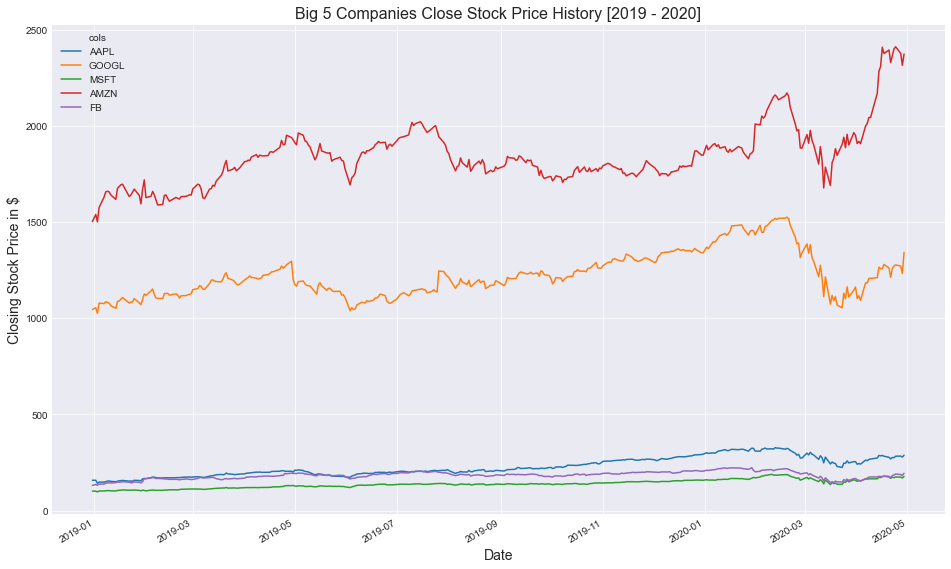

In [13]:
df_plot = df.reset_index().melt('Date', var_name='cols',  value_name='vals')
df_plot.isna().values.any()
# Create subplots to plot graph and control axes
fig, ax = plt.subplots(figsize=(16,10))
sns.lineplot(x="Date", y="vals", hue='cols', data=df_plot)

# Format the ticks
loc = mdates.AutoDateLocator()
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(loc))

# Set figure title
plt.title('Big 5 Companies Close Stock Price History [2019 - 2020]', fontsize=16)
# Set x label
plt.xlabel('Date', fontsize=14)
# Set y label
plt.ylabel('Closing Stock Price in $', fontsize=14)

# Rotate and align the x labels
fig.autofmt_xdate()

# Show plot
plt.show()

### Create X, y matrices for regression

In [114]:
def create_Xy(df, history=1):
    '''df has index as date
    columns are stock price of the companies
    '''
    X, y, dates = [], [], []
    for row_idx in range(history, len(df)):
        y.append( df.iloc[row_idx,:].values.reshape(-1) )
        X.append( df.iloc[row_idx-history:row_idx,:].values.reshape(-1) )
        dates.append(df.index[row_idx])
    X, y = np.array(X), np.array(y)
    return X, y, dates

X,y,dates = create_Xy(df, history=8)
# use 7/10 of the dataset to train (use past price to predict future price)
n_train = len(y) * 7 // 10
X_train, y_train, dates_train, X_test, y_test, dates_test = X[:n_train], y[:n_train], dates[:n_train], X[n_train:], y[n_train:], dates[n_train:]

In [115]:
X_train

array([[ 157.74000549, 1044.95996094,  101.56999969, ...,  103.59999847,
        1656.2199707 ,  144.19999695],
       [ 157.91999817, 1054.68005371,  101.12000275, ...,  102.80000305,
        1640.56005859,  143.80000305],
       [ 142.19000244, 1025.4699707 ,   97.40000153, ...,  102.05000305,
        1617.20996094,  145.38999939],
       ...,
       [ 263.19000244, 1301.85998535,  149.61999512, ...,  149.55000305,
        1781.59997559,  199.69999695],
       [ 262.01000977, 1300.14001465,  149.47999573, ...,  149.30999756,
        1769.95996094,  198.82000732],
       [ 261.77999878, 1293.67004395,  149.58999634, ...,  149.8500061 ,
        1760.68994141,  198.71000671]])

In [116]:
##clf = LinearRegression()
from sklearn.linear_model import Ridge
clf = Ridge(alpha=1.0)
clf.fit(X_train, y_train)
ypred = clf.predict(X_test)
mean_squared_error(y_test[:,0], ypred[:,0])

83.31303506383898

In [105]:
y_test[:,0]

array([265.57998657, 270.70999146, 266.92001343, 268.48001099,
       270.76998901, 271.45999146, 275.1499939 , 279.85998535,
       280.41000366, 279.73999023, 280.01998901, 279.44000244,
       284.        , 284.26998901, 289.91000366, 289.79998779,
       291.51998901, 293.6499939 , 300.3500061 , 297.42999268,
       299.79998779, 298.39001465, 303.19000244, 309.63000488,
       310.32998657, 316.95999146, 312.67999268, 311.33999634,
       315.23999023, 318.73001099, 316.57000732, 317.70001221,
       319.23001099, 318.30999756, 308.95001221, 317.69000244,
       324.33999634, 323.86999512, 309.51000977, 308.66000366,
       318.8500061 , 321.45001221, 325.20999146, 320.02999878,
       321.54998779, 319.60998535, 327.20001221, 324.86999512,
       324.95001221, 319.        , 323.61999512, 320.29998779,
       313.04998779, 298.17999268, 288.07998657, 292.6499939 ,
       273.51998901, 273.35998535, 298.80999756, 289.32000732,
       302.73999023, 292.92001343, 289.02999878, 266.17

In [91]:
ypred[:,0]

array([261.64984345, 265.93793019, 270.97965438, 267.47798899,
       269.1434239 , 271.45798615, 271.91002105, 275.80048641,
       280.20869439, 281.54705838, 280.36235482, 280.30391439,
       279.82838978, 284.79379489, 285.05786122, 290.51025935,
       290.23547159, 292.32629535, 294.10643571, 299.93192553,
       297.8547289 , 299.09854137, 298.58328345, 302.33618093,
       309.00836441, 309.94348504, 316.40769369, 312.76726493,
       310.82875213, 314.66938066, 317.70054488, 316.70631449,
       317.57161376, 318.87033149, 318.78611276, 309.9670815 ,
       317.20557573, 324.01524798, 323.53393178, 311.65388104,
       306.33820212, 319.32859193, 321.30959755, 323.83101149,
       319.87703424, 320.12325318, 319.84181611, 326.41549523,
       324.26448782, 323.67941208, 318.06843221, 322.93088027,
       319.98384095, 313.59644259, 299.77970203, 288.95250071,
       292.4846105 , 276.66305096, 272.5915751 , 297.34142598,
       291.92315607, 301.83375232, 295.25917765, 290.73

In [92]:
clf = LinearRegression()
clf.fit(X_train, y_train)
ypred = clf.predict(X_test)
mean_squared_error(y_test[:,0], ypred[:,0])

85.90575664934998

In [98]:
mse = []
for i in range(1,30):
    X,y,dates = create_Xy(df, history=i)
    n_train = len(y) * 7 // 10
    X_train, y_train, dates_train, X_test, y_test, dates_test = X[:n_train], y[:n_train], dates[:n_train], X[n_train:], y[n_train:], dates[n_train:]
    clf = LinearRegression()
    clf.fit(X_train, y_train)
    ypred = clf.predict(X_test)
    mse.append(mean_squared_error(y_test[:,0], ypred[:,0]))

In [99]:
mse

[91.66884147334338,
 85.90575664934998,
 87.92511428247221,
 86.66769484869872,
 89.49769268100353,
 89.94301799291378,
 88.75575130037325,
 83.2725366799056,
 86.13084299783307,
 88.49916944312646,
 91.22271850875788,
 101.80645460597235,
 108.74528776354319,
 116.38629834851689,
 130.64719478079397,
 147.10420926583814,
 150.9139370823306,
 168.17479794838815,
 204.84134972333348,
 259.6452135739707,
 202.29367314148146,
 236.33854601097036,
 312.0631579667043,
 313.42862477672804,
 302.33641424966845,
 439.03219163585413,
 371.64716557826324,
 544.9834019034917,
 655.6933538707821]

In [106]:
mse2 = []
for i in range(1,30):
    X,y,dates = create_Xy(df, history=i)
    n_train = len(y) * 7 // 10
    X_train, y_train, dates_train, X_test, y_test, dates_test = X[:n_train], y[:n_train], dates[:n_train], X[n_train:], y[n_train:], dates[n_train:]
    clf = Ridge(alpha=1.0)
    clf.fit(X_train, y_train)
    ypred = clf.predict(X_test)
    mse2.append(mean_squared_error(y_test[:,0], ypred[:,0]))

In [107]:
mse

[91.66884147334338,
 85.90575664934998,
 87.92511428247221,
 86.66769484869872,
 89.49769268100353,
 89.94301799291378,
 88.75575130037325,
 83.2725366799056,
 86.13084299783307,
 88.49916944312646,
 91.22271850875788,
 101.80645460597235,
 108.74528776354319,
 116.38629834851689,
 130.64719478079397,
 147.10420926583814,
 150.9139370823306,
 168.17479794838815,
 204.84134972333348,
 259.6452135739707,
 202.29367314148146,
 236.33854601097036,
 312.0631579667043,
 313.42862477672804,
 302.33641424966845,
 439.03219163585413,
 371.64716557826324,
 544.9834019034917,
 655.6933538707821]

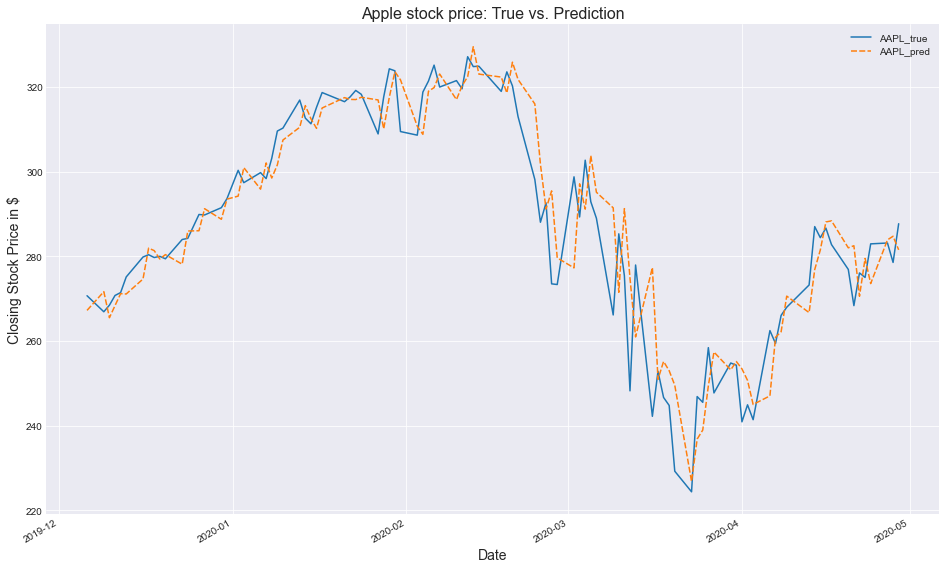

In [118]:
df_plot = pd.DataFrame({"AAPL_true": y_test[:,0], 'AAPL_pred': ypred[:,0]}, index=dates_test)

# Create subplots to plot graph and control axes
fig, ax = plt.subplots(figsize=(16,10))
sns.lineplot(data=df_plot)

# Format the ticks
loc = mdates.AutoDateLocator()
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(loc))

# Set figure title
plt.title('Apple stock price: True vs. Prediction', fontsize=16)
# Set x label
plt.xlabel('Date', fontsize=14)
# Set y label
plt.ylabel('Closing Stock Price in $', fontsize=14)

# Rotate and align the x labels
fig.autofmt_xdate()

# Show plot
plt.show()